# scRNA-seq For Kidney Cells Pipeline

In [1]:
# imports 
import pandas as pd
import scanpy as sc
import numpy as np
import os
import scipy
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scvi
import os
from pathlib import Path
import seaborn as sns
import datetime
import openpyxl
# # optional: nicer plots
# sc.settings.verbosity = 2
# sc.logging.print_header()

/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scanpy/readwrite.py:16: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):


In [2]:
print("Testing scAR availability...")
try:
    import scvi
    from scvi.external import SCAR
    print(f"✓ scvi-tools available (version {scvi.__version__})")
    scar_available = True
except ImportError as e:
    print(f"✗ scvi-tools not available: {e}")
    scar_available = False


Testing scAR availability...
✓ scvi-tools available (version 1.4.0)


In [3]:

# Data pathsData_files/raw_data
DATA_DIR = Path('/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/Data_files/raw_data')
RAW_H5 = DATA_DIR / '7_raw_feature_bc_matrix.h5'
FILTERED_H5 = DATA_DIR / '7_filtered_feature_bc_matrix.h5'
META_CSV = DATA_DIR / 'metadata.xlsx - Sheet1.csv'


print(f"✓ Setup complete")
print(f"  Raw H5: {RAW_H5.exists()}")
print(f"  Filtered H5: {FILTERED_H5.exists()}")
print(f"  Metadata CSV: {META_CSV.exists()}")

✓ Setup complete
  Raw H5: True
  Filtered H5: True
  Metadata CSV: True


In [4]:
# Load raw and filtered data
print("Loading data...")
raw = sc.read_10x_h5(str(RAW_H5))
filtered = sc.read_10x_h5(str(FILTERED_H5))
meta = pd.read_csv(str(META_CSV), index_col=0)

# Make var_names unique
raw.var_names_make_unique()
filtered.var_names_make_unique()

# Add metadata to filtered
sample_id = meta.index[0]
for col in meta.columns:
    filtered.obs[col] = meta.loc[sample_id, col]

# Save raw counts
filtered.layers['counts_raw'] = filtered.X.copy()
filtered.obs['sample_ID'] = meta.index.values[0]

print(f"✓ Data loaded")
print(f"  Raw: {raw.shape}")
print(f"  Filtered: {filtered.shape}")
print(f"  Sample ID: {sample_id}")

Loading data...


/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/anndata/_core/anndata.py:1794: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/anndata/_core/anndata.py:1794: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✓ Data loaded
  Raw: (1617288, 32285)
  Filtered: (8877, 32285)
  Sample ID: 7Dataset


/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/anndata/_core/anndata.py:1794: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/anndata/_core/anndata.py:1794: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [5]:
filtered

AnnData object with n_obs × n_vars = 8877 × 32285
    obs: 'animal_species', 'sex', 'age', 'tissue_type', 'treatment', 'processing_date', 'sample_type', 'sample_ID'
    var: 'gene_ids', 'feature_types', 'genome'
    layers: 'counts_raw'

In [6]:
raw

AnnData object with n_obs × n_vars = 1617288 × 32285
    var: 'gene_ids', 'feature_types', 'genome'

### QC Metrics

In [7]:
def compute_qc_metrics(adata, name=''):
    """Compute QC metrics for AnnData object."""
    X = adata.X
    
    if sp.issparse(X):
        total_counts = np.ravel(X.sum(axis=1))
        n_genes = np.ravel((X > 0).sum(axis=1))
    else:
        total_counts = X.sum(axis=1)
        n_genes = (X > 0).sum(axis=1)
    
    adata.obs['total_counts'] = total_counts
    adata.obs['n_genes'] = n_genes
    
    # Mitochondrial genes
    mt_mask = adata.var_names.str.upper().str.startswith('MT-')
    adata.var['mt'] = mt_mask
    
    if mt_mask.sum() > 0:
        if sp.issparse(X):
            mito_counts = np.ravel(X[:, mt_mask].sum(axis=1))
        else:
            mito_counts = X[:, mt_mask].sum(axis=1)
        adata.obs['pct_mito'] = mito_counts / adata.obs['total_counts'] * 100
    else:
        adata.obs['pct_mito'] = 0
    
    metrics = {
        'name': name,
        'mean_total_counts': float(total_counts.mean()),
        'median_total_counts': float(np.median(total_counts)),
        'std_total_counts': float(total_counts.std()),
        'mean_n_genes': float(n_genes.mean()),
        'median_n_genes': float(np.median(n_genes)),
        'std_n_genes': float(n_genes.std()),
        'mean_pct_mito': float(adata.obs['pct_mito'].mean()),
        'n_cells': adata.n_obs,
        'n_genes': adata.n_vars
    }
    return metrics, adata

# Compute baseline metrics
# baseline_metrics = compute_qc_metrics(filtered.copy(), 'baseline')
# print("✓ QC metrics computed")
# print(f"  Mean counts: {baseline_metrics['mean_total_counts']:.2f}")
# print(f"  Mean genes: {baseline_metrics['mean_n_genes']:.2f}")
# print(f"  Mean % mito: {baseline_metrics['mean_pct_mito']:.2f}")


## Ambient RNA

### Ambient RNA using Knee Plot Method

In [8]:
def knee_plot(raw, filtered, min_counts=100):

    all_droplets = pd.DataFrame(raw.X.sum(axis=1), index=raw.obs_names, columns=['total_counts'])
    all_droplets['droplets'] = 'cell-free droplets'
    all_droplets['droplets'] = all_droplets['droplets'].mask(all_droplets['total_counts']>min_counts, 'other droplets')
    all_droplets['droplets'] = all_droplets['droplets'].mask(all_droplets.index.isin(filtered.obs_names), 'cells')
    all_droplets.index.name = 'barcode'
    all_droplets = all_droplets.sort_values(by='total_counts', ascending=False).reset_index().rename_axis("rank").reset_index()
    all_droplets = all_droplets.loc[all_droplets['total_counts']>0]
    all_droplets = all_droplets.set_index('barcode').rename_axis('cells')

    plt.figure(figsize=(3, 2), dpi=150)
    ax = sns.lineplot(
        data=all_droplets,
        x='rank',
        y='total_counts',
        hue='droplets',
        hue_order=['other droplets', 'cell-free droplets', 'cells'],
        palette=sns.color_palette()[-3:],
        markers=False,
        lw=2,
        ci=None
    )
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('sorted droplets');
    ax.legend(loc='lower left', ncol=1, title=None, frameon=False)
    ax.set_title(f'kneeplot')
    sns.set_palette('muted')
    sns.set_style('ticks')
    sns.despine(offset=10, trim=False)

    cell_free = raw[raw.obs_names.isin(all_droplets[all_droplets['droplets']=='cell-free droplets'].index)].copy()
    cell_free = cell_free[:, filtered.var_names]
    # average and normalize the transcript in cell-free droplets
    ambient_profile = pd.DataFrame((cell_free.X.sum(axis=0)/cell_free.X.sum()).A1, index=filtered.var_names, columns=['ambient profile'])
    return ambient_profile

### Ambient RNA Removal using SCAR

In [9]:

def denoise_with_scar(raw_adata, filtered_adata, max_epochs=10, prob=0.995):
    """
    Remove ambient RNA from filtered counts using SCAR model trained on raw data.
    
    Follows the scVI-tools SCAR workflow:
    1. Estimate ambient profile from raw (unfiltered) droplets
    2. Train SCAR model to learn cell-specific denoising
    3. Apply denoised counts to filtered cells
    
    Parameters:
    -----------
    raw_adata : AnnData
        Raw (unfiltered) count matrix with all droplets
    filtered_adata : AnnData
        Filtered count matrix (cells only)
    max_epochs : int
        Number of epochs to train SCAR model (default: 10)
    prob : float
        Probability threshold for ambient profile estimation (default: 0.995)
        Higher = more conservative in identifying cell-free droplets
    
    Returns:
    --------
    filtered_adata : AnnData
        Updated with denoised counts in layers['denoised']
    """
    
    print("=" * 60)
    print("SCAR: Ambient RNA Removal")
    print("=" * 60)
    
    # Step 1: Prepare raw data
    print("\n[1/6] Preparing raw data for ambient profile estimation...")
    raw_for_scar = raw_adata.copy()
    filtered_for_scar = filtered_adata.copy()
    
    # Ensure counts layer exists
    if 'counts' not in filtered_for_scar.layers:
        filtered_for_scar.layers['counts'] = filtered_for_scar.X.copy()
    
    # Step 2: Setup SCAR for raw data
    print("[2/6] Setting up SCAR for raw data...")
    SCAR.setup_anndata(filtered_for_scar)
    
    # Step 3: Estimate ambient profile using EmptyDrops-inspired method
    print("[3/6] Estimating ambient profile from raw data...")
    print(f"      Using probability threshold: {prob}")
    SCAR.get_ambient_profile(adata=filtered_for_scar, raw_adata=raw_for_scar, prob=prob)
    print(f"      ✓ Ambient profile saved to raw_adata.varm['ambient_profile']")
    
    # Step 4: Train SCAR model on raw data
    print(f"[4/6] Training SCAR model on raw data (max_epochs={max_epochs})...")
    scar_model = SCAR(filtered_for_scar, ambient_profile="ambient_profile")
    scar_model.train(max_epochs=max_epochs)
    print(f"      ✓ Model trained")
    

    # Step 5: Get denoised counts for filtered cells
    print("[6/6] Generating denoised counts...")
    denoised_counts = scar_model.get_denoised_counts()

    
    # Store denoised counts in layers
    filtered_adata.layers['denoised'] = denoised_counts
    filtered_adata.obsm['X_scar'] = scar_model.get_latent_representation()
    
    print("\n" + "=" * 60)
    print("✓ SCAR denoising complete!")
    print("=" * 60)
    print(f"Results stored in filtered_adata.layers:")
    print(f"  - 'counts'   : Original count matrix")
    print(f"  - 'denoised' : Ambient-corrected counts")
    print(f"\nYou can now use filtered_adata.layers['denoised'] for downstream analysis")
    
    return filtered_adata

# Run SCAR denoising on filtered data using raw for ambient profile
#filtered = denoise_with_scar(raw, filtered, max_epochs=3, prob=0.995)


## Mitochondrial Genes

In [10]:
X = filtered.X.copy()

In [11]:
def compute_mito_metrics(filtered, X):
    # 4) percent mitochondrial genes (mouse mm10) — create var boolean and call Scanpy QC
    # Use uppercase comparator for safety (genes like 'Mt-...' or 'mt-...')
    mt_mask = filtered.var_names.str.upper().str.startswith('mt-')
    filtered.var['mt'] = mt_mask

    # Use scanpy convenience to compute per-cell QC stats from that var column
    # This will add e.g. n_genes_by_counts, total_counts_mt, pct_counts_mt (names depend on scanpy version)
    sc.pp.calculate_qc_metrics(filtered, qc_vars=['mt'], inplace=True)

    # also keep a simple pct_mito column for downstream clarity (sometimes names differ)
    if 'total_counts_mt' in filtered.obs.columns:
        filtered.obs['pct_mito'] = filtered.obs['total_counts_mt'] / filtered.obs['total_counts'] * 100
    elif 'pct_counts_mt' in filtered.obs.columns:
        # Scanpy may already produce this
        filtered.obs['pct_mito'] = filtered.obs['pct_counts_mt']
    else:
        # manual fallback
        if sp.issparse(X):
            mito_counts = np.ravel(X[:, mt_mask].sum(axis=1))
        else:
            mito_counts = X[:, mt_mask].sum(axis=1)
        filtered.obs['pct_mito'] = mito_counts / filtered.obs['total_counts'] * 100

    # inspect QC columns
    filtered.obs[['total_counts', 'n_genes', 'pct_mito']].describe().T
    return filtered


In [12]:
# # 5) Visualize QC distributions (choose thresholds after inspection)
# fig, axes = plt.subplots(1,3, figsize=(14,4))
# sc.pl.violin(filtered, keys='total_counts', groupby=None, show=False, ax=axes[0])
# sc.pl.violin(filtered, keys='n_genes', groupby=None, show=False, ax=axes[1])
# sc.pl.violin(filtered, keys='pct_mito', groupby=None, show=False, ax=axes[2])
# plt.tight_layout()


## Filter Genes

In [13]:
def filter_genes(filtered, min_genes=200, min_counts=500, pct_mito_thresh=10.0):
    # 6) Suggested filtering (defaults — tune these per distributions and snRNA vs scRNA)
    # NOTE: your meta.sample_type shows 'snRNAseq' — mitochondrial percentage often differs for nuclei (lower),
    # so inspect distributions before aggressive mito filtering. These are starting suggestions.

    # min_genes = 200          # cells with <200 genes -> drop
    # min_counts = 500         # cells with <500 counts -> drop
    # max_counts = np.percentile(filtered.obs['total_counts'], 99.9)  # remove extremely high outliers
    # pct_mito_thresh = 10.0   # conservative for snRNA; increase for scRNA if needed (often 20%)
    max_counts=np.percentile(filtered.obs['total_counts'], 99.9)
    mask = (
        (filtered.obs['n_genes'] >= min_genes) &
        (filtered.obs['total_counts'] >= min_counts) &
        (filtered.obs['total_counts'] <= max_counts) &
        (filtered.obs['pct_mito'] <= pct_mito_thresh)
    )

    print("Cells before:", filtered.n_obs)
    filtered = filtered[mask].copy()
    print("Cells after:", filtered.n_obs)
    return filtered


In [14]:
# # 7) Filter genes: remove genes expressed in very few cells
# min_cells = 3
# sc.pp.filter_genes(filtered, min_cells=min_cells)
# print("Vars after filtering:", filtered.n_vars)


In [15]:
# # 5) Visualize QC distributions (choose thresholds after inspection)
# fig, axes = plt.subplots(1,3, figsize=(14,4))
# sc.pl.violin(filtered, keys='total_counts', groupby=None, show=False, ax=axes[0])
# sc.pl.violin(filtered, keys='n_genes', groupby=None, show=False, ax=axes[1])
# sc.pl.violin(filtered, keys='pct_mito', groupby=None, show=False, ax=axes[2])
# plt.tight_layout()


## Doublet Detection

In [16]:
import numpy as np
import scanpy as sc
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import pandas as pd

def doubletfinder_style(adata, expected_doublet_rate=0.06, pN=0.25, pK=0.01, 
                        n_prin_comps=30, use_sct=False):
    """
    Python implementation mimicking DoubletFinder's approach
    """
    # Get counts matrix
    if 'counts' in adata.layers:
        counts = adata.layers['counts'].copy()
    else:
        counts = adata.X.copy()
    
    # Convert to dense if sparse
    if scipy.sparse.issparse(counts):
        counts = counts.toarray()
    
    n_cells = counts.shape[0]
    
    # Step 1: Generate artificial doublets
    n_doublets = int(n_cells * 2)  # typically 2x the number of real cells
    doublet_ids = np.random.choice(n_cells, size=(n_doublets, 2))
    artificial_doublets = counts[doublet_ids[:, 0]] + counts[doublet_ids[:, 1]]
    
    # Step 2: Combine real and artificial cells
    combined = np.vstack([counts, artificial_doublets])
    
    # Step 3: Normalize and PCA
    # Create temporary AnnData for processing
    combined_adata = sc.AnnData(combined)
    sc.pp.normalize_total(combined_adata, target_sum=1e4)
    sc.pp.log1p(combined_adata)
    sc.pp.scale(combined_adata)
    
    # PCA
    sc.tl.pca(combined_adata, n_comps=n_prin_comps)
    pca_coords = combined_adata.obsm['X_pca']
    
    # Step 4: Calculate pANN for each real cell
    real_coords = pca_coords[:n_cells]
    all_coords = pca_coords
    
    # Find optimal pK using BCmvn (this is simplified)
    if pK == 'auto':
        pK = 0.01  # Default, in practice you'd sweep parameters
    
    k = int(pK * n_cells)
    
    # Calculate nearest neighbors
    nn = NearestNeighbors(n_neighbors=k, algorithm='auto')
    nn.fit(all_coords)
    distances, indices = nn.kneighbors(real_coords)
    
    # Calculate pANN (proportion of artificial nearest neighbors)
    pANN = np.zeros(n_cells)
    for i in range(n_cells):
        neighbors = indices[i]
        pANN[i] = np.sum(neighbors >= n_cells) / k
    
    # Step 5: Classify doublets based on expected rate
    n_doublets_expected = int(expected_doublet_rate * n_cells)
    threshold_idx = np.argsort(pANN)[-n_doublets_expected]
    threshold = pANN[threshold_idx]
    
    # Classify
    doublet_class = np.where(pANN >= threshold, 'Doublet', 'Singlet')
    
    # Add to adata
    adata.obs['pANN'] = pANN
    adata.obs['DF.class'] = doublet_class
    
    return adata

### Manual Doublet Curation based on Marker Expression

In [17]:
def identify_doublet_clusters(adata, marker_dict, avg_exp_threshold=2.0):
    """
    Identify potential doublet clusters based on marker expression patterns
    
    Parameters:
    -----------
    adata : AnnData object with clusters identified
    marker_dict : dict of cell type markers
    avg_exp_threshold : threshold for considering expression significant
    """
    
    # Calculate average expression per cluster
    cluster_key = 'leiden'  # or your cluster column
    
    # Get expression data for markers
    all_markers = []
    for cell_type, markers in marker_dict.items():
        all_markers.extend(markers)
    all_markers = list(set(all_markers))
    
    # Filter to markers present in data
    present_markers = [m for m in all_markers if m in adata.var_names]
    
    # Calculate mean expression per cluster
    cluster_expression = pd.DataFrame()
    for cluster in adata.obs[cluster_key].unique():
        mask = adata.obs[cluster_key] == cluster
        cluster_data = adata[mask, present_markers]
        
        # Use raw or normalized data
        if 'counts' in cluster_data.layers:
            expr_data = cluster_data.layers['counts']
        else:
            expr_data = cluster_data.X
            
        if scipy.sparse.issparse(expr_data):
            mean_expr = np.array(expr_data.mean(axis=0)).flatten()
        else:
            mean_expr = expr_data.mean(axis=0)
            
        cluster_expression[cluster] = mean_expr
    
    cluster_expression.index = present_markers
    
    # Identify doublet clusters
    # Look for clusters expressing markers from multiple incompatible cell types
    doublet_clusters = []
    
    for cluster in cluster_expression.columns:
        expr = cluster_expression[cluster]
        
        # Check if cluster has low overall expression (potential doublet)
        if (expr < avg_exp_threshold).all():
            doublet_clusters.append(cluster)
            continue
            
        # Check for co-expression of incompatible markers
        cell_types_expressed = []
        for cell_type, markers in marker_dict.items():
            markers_present = [m for m in markers if m in present_markers]
            if any(expr[m] > avg_exp_threshold for m in markers_present):
                cell_types_expressed.append(cell_type)
        
        # If expressing markers from incompatible cell types
        incompatible_pairs = [
            ('Proximal_Tubule', 'Endothelial'),
            ('Proximal_Tubule', 'Fibroblast'),
            ('Proximal_Tubule', 'TAL'),
            # Add more incompatible pairs
        ]
        
        for pair in incompatible_pairs:
            if pair[0] in cell_types_expressed and pair[1] in cell_types_expressed:
                doublet_clusters.append(cluster)
                break
    
    return list(set(doublet_clusters)), cluster_expression
    

## Cell Type Annotation 

In [18]:
def annotate_kidney_cells(adata, cluster_key='leiden'):
    """
    Annotate kidney cells based on marker expression
    Following the hierarchy: subclass -> class -> type
    """
    
    # Define kidney cell markers (from R framework)
    kidney_markers = {
        'PTS1': ['Lrp2', 'Slc5a12'],
        'PTS2': ['Lrp2', 'Slc13a3'],
        'PTS3': ['Lrp2', 'Slc16a9'],
        'DTL': ['Epha7', 'Cryab'],
        'TALA': ['Slc12a1', 'Cldn16'],
        'TALB': ['Slc12a1', 'Cldn10'],
        'MD': ['Nos1', 'Slc12a1'],
        'DCT1': ['Slc12a3', 'Egf'],
        'DCT2': ['Slc12a3', 'Slc8a1'],
        'CNT': ['Slc8a1'],
        'PC': ['Aqp2'],
        'ICA': ['Slc4a1', 'Kit'],
        'ICB': ['Slc26a4'],
        'PODO': ['Nphs1', 'Nphs2'],
        'EC': ['Flt1', 'Emcn', 'Pecam1'],
        'FIB': ['Pdgfra', 'Col1a1'],
        'MES': ['Pdgfrb', 'Piezo2'],
        'LYMPHO': ['Ptprc', 'Skap1'],
        'MACRO': ['Ptprc', 'Cd74', 'Cd68']
    }
    
    # Score each cluster for each cell type
    def score_cluster(adata, cluster_id, markers):
        """Calculate marker score for a cluster"""
        cluster_cells = adata.obs[cluster_key] == cluster_id
        present_markers = [m for m in markers if m in adata.var_names]
        
        if not present_markers:
            return 0
        
        # Get expression
        expr = adata[cluster_cells, present_markers].X
        if scipy.sparse.issparse(expr):
            expr = expr.toarray()
        
        # Calculate percentage of cells expressing and mean expression
        pct_expressing = (expr > 0).mean(axis=0)
        mean_expr = expr.mean(axis=0)
        
        # Combined score
        score = np.mean(pct_expressing) * np.mean(mean_expr)
        return score
    
    # Annotate each cluster
    cluster_annotations = {}
    
    for cluster in adata.obs[cluster_key].unique():
        scores = {}
        for cell_type, markers in kidney_markers.items():
            scores[cell_type] = score_cluster(adata, cluster, markers)
        
        # Assign to highest scoring cell type
        if max(scores.values()) > 0:
            cluster_annotations[cluster] = max(scores, key=scores.get)
        else:
            cluster_annotations[cluster] = 'Unknown'
    
    # Add annotations to adata
    adata.obs['subclass'] = adata.obs[cluster_key].map(cluster_annotations)
    
    # Define hierarchical mappings
    subclass_to_class = {
        'PTS1': 'PT', 'PTS2': 'PT', 'PTS3': 'PT',
        'DTL': 'DTL',
        'TALA': 'TAL', 'TALB': 'TAL', 'MD': 'TAL',
        'DCT1': 'DCT', 'DCT2': 'DCT',
        'CNT': 'CNT',
        'PC': 'PC',
        'ICA': 'ICA', 'ICB': 'ICB',
        'PODO': 'PODO',
        'EC': 'EC',
        'FIB': 'FIB',
        'MES': 'MES',
        'LYMPHO': 'IMMUNE', 'MACRO': 'IMMUNE'
    }
    
    class_to_type = {
        'PT': 'EPITHELIAL', 'DTL': 'EPITHELIAL', 'TAL': 'EPITHELIAL',
        'DCT': 'EPITHELIAL', 'CNT': 'EPITHELIAL', 'PC': 'EPITHELIAL',
        'ICA': 'EPITHELIAL', 'ICB': 'EPITHELIAL', 'PODO': 'EPITHELIAL',
        'EC': 'ENDOTHELIAL',
        'FIB': 'STROMAL', 'MES': 'STROMAL',
        'IMMUNE': 'IMMUNE'
    }
    
    adata.obs['class'] = adata.obs['subclass'].map(subclass_to_class)
    adata.obs['type'] = adata.obs['class'].map(class_to_type)
    
    return adata


### Multidimensional DotPlot

In [19]:
def create_kidney_dotplot(adata, markers=None, groupby='subclass', 
                          save_path=None, figsize=(12, 8)):
    """
    Create a dotplot similar to Seurat's DotPlot for kidney markers
    """
    
    if markers is None:
        # Default kidney markers
        markers = [
            'Lrp2', 'Slc5a12', 'Slc13a3', 'Slc16a9',  # PT
            'Epha7', 'Cryab',  # DTL
            'Slc12a1', 'Cldn16', 'Cldn10', 'Nos1',  # TAL
            'Slc12a3', 'Egf', 'Slc8a1',  # DCT/CNT
            'Aqp2',  # PC
            'Slc4a1', 'Kit', 'Slc26a4',  # IC
            'Nphs1',  # PODO
            'Flt1', 'Emcn',  # EC
            'Pdgfra', 'Pdgfrb', 'Piezo2',  # FIB/MES
            'Ptprc', 'Cd74'  # IMMUNE
        ]
    
    # Filter to present markers
    markers_present = [m for m in markers if m in adata.var_names]
    
    # Create the dotplot
    sc.pl.dotplot(
        adata,
        markers_present,
        groupby=groupby,
        dendrogram=False,
        standard_scale='var',
        swap_axes=True,
        figsize=figsize,
        save=save_path,
        return_fig=True
    )
    
    return markers_present

### QC Summary Stats

In [20]:
def generate_qc_report(adata, sample_name, output_dir='./outputs'):
    """
    Generate comprehensive QC report matching the R framework
    """
    import os
    from datetime import datetime
    
    os.makedirs(output_dir, exist_ok=True)
    
    report = {
        'Sample': sample_name,
        'Date': datetime.now().strftime('%Y-%m-%d'),
        'Initial_Cells': adata.n_obs,
        'Final_Cells': adata.n_obs,
        'Genes_Detected': adata.n_vars,
        'Filtering_Steps': []
    }
    
    # Track filtering
    if 'DF.class' in adata.obs.columns:
        n_doublets = (adata.obs['DF.class'] == 'Doublet').sum()
        report['Filtering_Steps'].append(f"DoubletFinder: {n_doublets} cells removed")
    
    # Cell type composition
    if 'subclass' in adata.obs.columns:
        composition = adata.obs['subclass'].value_counts()
        report['Cell_Type_Composition'] = composition.to_dict()
        
        # Missing cell types
        expected_types = ['PTS1', 'PTS2', 'PTS3', 'DTL', 'TALA', 'TALB', 
                          'DCT1', 'DCT2', 'CNT', 'PC', 'ICA', 'ICB', 
                          'PODO', 'EC', 'FIB', 'MES']
        missing = [t for t in expected_types if t not in composition.index]
        report['Missing_Cell_Types'] = missing
    
    # Save report
    import json
    with open(f"{output_dir}/{sample_name}_qc_report.json", 'w') as f:
        json.dump(report, f, indent=2, default=str)
    
    return report

## Find and Export Markers to Excel

In [21]:
def find_all_markers(adata, groupby='subclass', output_path=None):
    """
    Find markers for all groups and export to Excel
    """
    import pandas as pd
    from datetime import datetime
    
    # Run differential expression
    sc.tl.rank_genes_groups(adata, groupby, method='wilcoxon', 
                            pts=True, key_added='rank_genes')
    
    # Extract results
    result = adata.uns['rank_genes']
    groups = result['names'].dtype.names
    
    # Create Excel writer
    if output_path is None:
        date = datetime.now().strftime('%Y%m%d')
        output_path = f"{date}_FindAllMarkers_By_{groupby}.xlsx"
    
    with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
        for group in groups:
            # Get markers for this group
            df = sc.get.rank_genes_groups_df(adata, group=group, 
                                            key='rank_genes')
            
            # Sort by log fold change
            df = df.sort_values('logfoldchanges', ascending=False)
            
            # Write to Excel
            df.to_excel(writer, sheet_name=str(group), index=False)
    
    print(f"Markers saved to {output_path}")
    return output_path

# Integration Function

Step 1: Ambient RNA correction...
SCAR: Ambient RNA Removal

[1/6] Preparing raw data for ambient profile estimation...
[2/6] Setting up SCAR for raw data...
[3/6] Estimating ambient profile from raw data...
      Using probability threshold: 0.995
Randomly sampling 50000 droplets to calculate the ambient profile.


Working...:   0%|          | 0/3 [00:00<?, ?it/s]

/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scvi/external/scar/_model.py:252: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  raw_adata.obs["log_prob"] = log_prob
/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scvi/train/_trainrunner.py:82: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


      ✓ Ambient profile saved to raw_adata.varm['ambient_profile']
[4/6] Training SCAR model on raw data (max_epochs=10)...


/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.


Training:   0%|          | 0/10 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


      ✓ Model trained
[6/6] Generating denoised counts...

✓ SCAR denoising complete!
Results stored in filtered_adata.layers:
  - 'counts'   : Original count matrix
  - 'denoised' : Ambient-corrected counts

You can now use filtered_adata.layers['denoised'] for downstream analysis
Step 2: QC filtering...
QC report generated for Kidney_7 after step 1: {'name': 'after_scar', 'mean_total_counts': 6366.947265625, 'median_total_counts': 3929.0, 'std_total_counts': 10179.990234375, 'mean_n_genes': 2255.7118395854454, 'median_n_genes': 1877.0, 'std_n_genes': 1535.7098537351583, 'mean_pct_mito': 0.6923648715019226, 'n_cells': 8877, 'n_genes': 32285}
AnnData object with n_obs × n_vars = 8877 × 32285
    obs: 'animal_species', 'sex', 'age', 'tissue_type', 'treatment', 'processing_date', 'sample_type', 'sample_ID', 'total_counts', 'n_genes', 'pct_mito'
    var: 'gene_ids', 'feature_types', 'genome', 'mt'
    obsm: 'X_scar'
    layers: 'counts_raw', 'denoised'
Cells before: 8877
Cells after: 8848

/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scanpy/preprocessing/_pca/__init__.py:245: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  Version(ad.__version__) < Version("0.9")


Step 4: Clustering...


/opt/homebrew/Cellar/python@3.13/3.13.9/Frameworks/Python.framework/Versions/3.13/lib/python3.13/functools.py:934: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scanpy/preprocessing/_pca/__init__.py:245: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  Version(ad.__version__) < Version("0.9")
/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scanpy/neighbors/__init__.py:430: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if "X_diffmap" in adata.obsm_keys():


Step 5: Manual doublet curation...
Step 6: Annotating cell types...
Step 7: Creating visualizations...


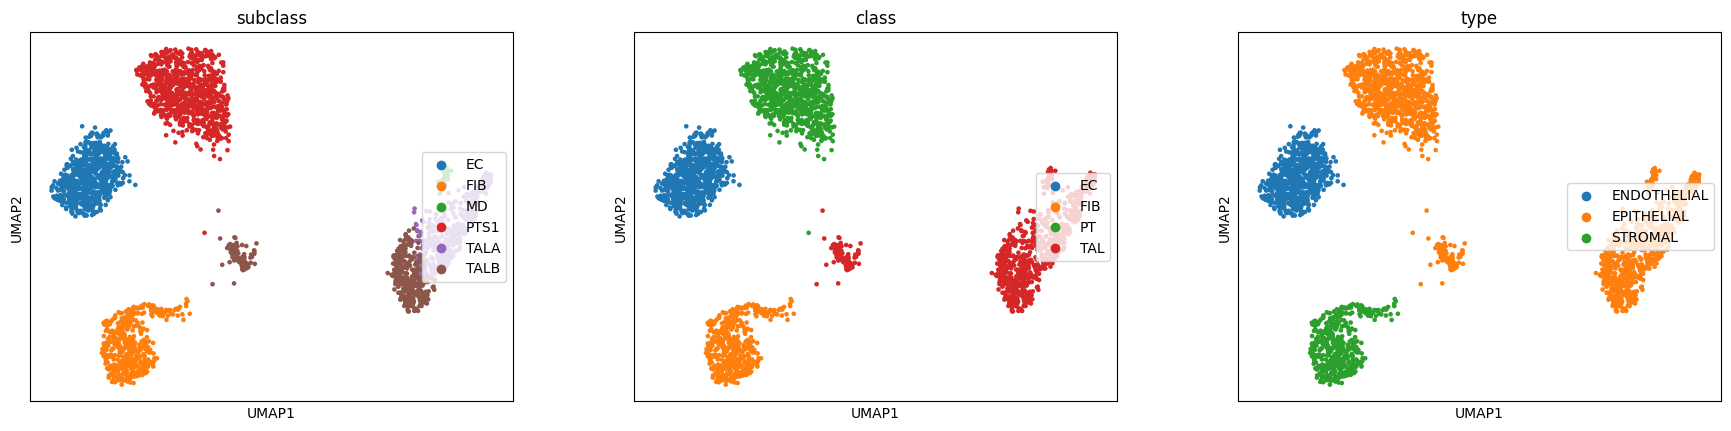

/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scanpy/plotting/_anndata.py:2074: FutureWarning: Use obs (e.g. `k in adata.obs` or `str(adata.obs.columns.tolist())`) instead of AnnData.obs_keys, AnnData.obs_keys is deprecated and will be removed in the future.
  if group not in [*adata.obs_keys(), adata.obs.index.name]:


Step 8: Finding markers...


/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/michaelhaidar/Documen

Markers saved to 20251018_FindAllMarkers_By_subclass.xlsx
Step 9: Generating QC report...
QC report generated for Kidney_7 after step 9: {'Sample': 'Kidney_7', 'Date': '2025-10-18', 'Initial_Cells': 2709, 'Final_Cells': 2709, 'Genes_Detected': 32285, 'Filtering_Steps': ['DoubletFinder: 0 cells removed'], 'Cell_Type_Composition': {'PTS1': 814, 'EC': 655, 'FIB': 460, 'TALB': 418, 'TALA': 331, 'MD': 31}, 'Missing_Cell_Types': ['PTS2', 'PTS3', 'DTL', 'DCT1', 'DCT2', 'CNT', 'PC', 'ICA', 'ICB', 'PODO', 'MES']}
Step 10: Saving results...
Analysis complete!


In [26]:
def complete_kidney_analysis_pipeline(adata, sample_name, raw_adata):
    """
    Complete kidney scRNAseq analysis pipeline
    """
    
    # 1. Ambient RNA correction (already done in your code)
    print("Step 1: Ambient RNA correction...")
    adata = denoise_with_scar(raw_adata, adata, max_epochs=10, prob=0.995)
    
    # 2. Quality control filtering (already done)
    print("Step 2: QC filtering...")
    metrics_after_scar,adata = compute_qc_metrics(adata.copy(), 'after_scar')
    print(f"QC report generated for {sample_name} after step 1: {metrics_after_scar}")

    print(adata)

    adata = filter_genes(adata.copy(), min_genes=200, min_counts=500, pct_mito_thresh=10.0)

    
    # 3. Enhanced doublet detection
    print("Step 3: Running DoubletFinder-style detection...")
    adata = doubletfinder_style(adata, expected_doublet_rate=0.06)
    
    # Remove doublets
    adata = adata[adata.obs['DF.class'] == 'Singlet'].copy()
    
    # 4. Clustering
    print("Step 4: Clustering...")
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000)
    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, n_comps=40)
    sc.pp.neighbors(adata, n_pcs=40)
    sc.tl.leiden(adata, resolution=2.0)  # Match R resolution
    sc.tl.umap(adata)
    
    # 5. Manual doublet curation
    print("Step 5: Manual doublet curation...")
    kidney_markers = {
        'Proximal_Tubule': ['Lrp2', 'Slc5a12', 'Slc13a3', 'Slc16a9'],
        'Endothelial': ['Flt1', 'Emcn', 'Pecam1'],
        'Fibroblast': ['Pdgfra', 'Col1a1'],
        'TAL': ['Slc12a1', 'Cldn16', 'Cldn10']
    }
    
    doublet_clusters, expr_matrix = identify_doublet_clusters(adata, kidney_markers)
    
    if doublet_clusters:
        adata.obs['manual_doublet'] = adata.obs['leiden'].isin(doublet_clusters)
        adata = adata[~adata.obs['manual_doublet']].copy()
        
        # Re-cluster after removing doublets
        sc.tl.leiden(adata, resolution=2.0)
    
    # 6. Cell type annotation
    print("Step 6: Annotating cell types...")
    adata = annotate_kidney_cells(adata)
    
    # 7. Generate visualizations
    print("Step 7: Creating visualizations...")
    
    # UMAP plots
    sc.pl.umap(adata, color=['subclass', 'class', 'type'], 
               legend_loc='right', save=f'_{sample_name}_annotation.pdf')
    
    # Dotplot
    create_kidney_dotplot(adata, groupby='subclass', 
                         save_path=f'{sample_name}_dotplot.pdf')
    
    # 8. Find markers
    print("Step 8: Finding markers...")
    find_all_markers(adata, groupby='subclass')
    
    # 9. Generate QC report
    print("Step 9: Generating QC report...")
    report = generate_qc_report(adata, sample_name)
    print(f"QC report generated for {sample_name} after step 9: {report}")
    # 10. Save final object
    print("Step 10: Saving results...")
    date = datetime.datetime(2025, 10, 18)
    adata.write_h5ad(f"{date}_{sample_name}_annotated.h5ad")
    
    print("Analysis complete!")
    return adata

# Run the complete pipeline
adata_final = complete_kidney_analysis_pipeline(filtered, "Kidney_7", raw)